# Section 20. The Euler method (cont'd)

from Chapter 2. Numerical Differentail Equation Methods in Butcher "Numerical methods for ordinary differential equations," 2nd ed., Wiley, 2008.

$$
\newcommand{\bv}[1]{\pmb{#1}}
\newcommand{\df}[2]{\frac{d #1}{d #2}}
\newcommand{\pf}[2]{\frac{\partial #1}{\partial #2}}
%
\newcommand{\pr}[1]{\!\left( #1 \right)}
%
\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}
%
\newcommand{\pmat}[1]{\begin{pmatrix} #1 \end{pmatrix}} % \pmat{1 & 2 \\ 3 & 4}
\newcommand{\mat}[1]{\left( \begin{matrix} #1 \end{matrix} \right)}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numba import njit, jit

"§203 Calculations with mildly stiff problems"と"§204 Calculations with the implicit Euler method"を参考にして，"stiff problem"の場合に，
- explicit Euler method
    - with constant stepsize
    - with variable stepsize
- implicit Euler method
の比較をする．

#### 定義
$x \in [x_{min}, x_{max}]$を時刻(独立変数)，$\bv{y}(x) \in \mathbb{R}^m$を従属変数とする．
また関数$\bv{f}(x, \bv{y}(x))$を，$\bv{f}:[x_{min}, x_{max}] \times \mathbb{R}^m \rightarrow \mathbb{R}^m$とする．

このとき，
$$
\bv{y}'(x) = \bv{f}(x, \bv{y}(x)), \quad \bv{y}(x_{min}) = \bv{y}_0
$$
から$\bv{y}(x)$を求める問題を，常微分方程式の初期値問題という．(ただし$\bv{y}'(x) = \df{\bv{y}}{x}(x)$)

#### 考える問題 (midly stiff problem)
$$
\begin{align*}
&\df{y_1}{x} = -16y_1 + 12y_2 + 16\cos x - 13\sin x, \quad & y_1(0) = 1, \\
&\df{y_2}{x} = 12y_1 - 9y_2 - 11\cos x + 9\sin x, \quad & y_2(0) = 0.
\end{align*}
$$

厳密解は，
$$
\begin{align*}
y_1(x) &= \cos x \\
y_2(x) &= \sin x
\end{align*}
$$

In [2]:
@njit
def stiff1(x, y):
    y1, y2 = y
    dydx = np.array([
        -16.*y1 + 12.*y2 + 16.*np.cos(x) - 13.*np.sin(x),
         12.*y1 -  9.*y2 - 11.*np.cos(x) +  9.*np.sin(x)
    ], dtype=np.float64)
    return dydx

y0 = np.array([1., 0.])

def stiff1_exact(xs):
    ys = np.array([np.cos(xs), np.sin(xs)]).T
    return ys

#### Explicit Euler (constant stepsize)

Input:
- $\bv{f}(x, \bv{y})$
- interval of integration, $x_{min}, x_{max}$
- initial values, $\bv{y}(x_{min})$
- stepsize, $h$

時刻$x_{n-1}$の値$\bv{y}(x_{n-1})$から，時刻$x_{n} = x_{n-1} + h$の値$\bv{y}(x_{n})$を次のようにして求める:
$$
\begin{align*}
\bv{y}(x_{n}) &= \bv{y}(x_{n-1}) + h \bv{y}'(x_{n-1}) \\
& = \bv{y}(x_{n-1}) + h \bv{f}(x_{n-1}, \bv{y}(x_{n-1}) )
\end{align*}
$$
(ただし$n=0, 1, \ldots, N$とし，$x_0 = x_{min}$とする)

> この式は，Taylor展開
> $$\bv{y}(x_{n}) = \bv{y}(x_{n-1}+h) = \bv{y}(x_{n-1}) + \bv{y}'(x_{n-1})h + \frac{1}{2!} \bv{y}''(x_{n-1})h^2 + \cdots$$
> の$h^2$以上の項を打ち切ったもの．


In [3]:
class ExplicitEulerWithConstantStepsize:
    def __init__(self, func, xlim, y0, n_steps):
        self.func = func
        self.xlim = xlim
        self.y0   = y0
        self.n_steps = n_steps
    
    def solve(self):
        self.xs, self.ys = self._solve(
            func = self.func, 
            xlim = self.xlim, 
            y0   = np.array(self.y0, dtype=np.float64), 
            n_steps = self.n_steps
        )
        return self
    
    @staticmethod
    @njit
    def _solve(func, xlim, y0, n_steps):
        xs = np.linspace(xlim[0], xlim[1], n_steps)
        ys = np.zeros(shape=(len(xs), len(y0)), dtype=np.float64)
        ys[0,:] = y0
        
        for i in range(1, len(xs)):
            h = xs[i] - xs[i-1]
            ys[i,:] = ys[i-1,:] + h*func(xs[i-1], ys[i-1,:])
            
        return xs, ys

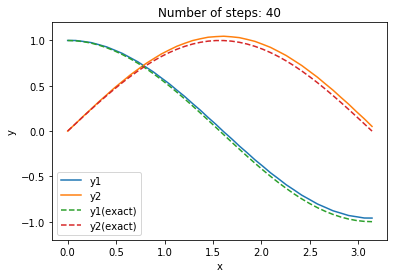

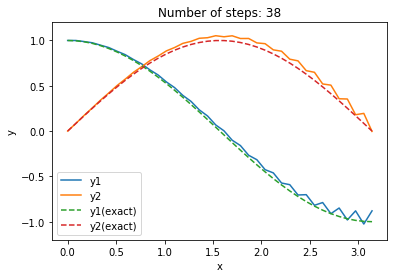

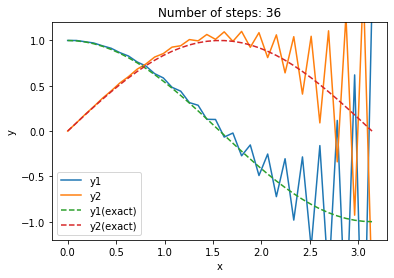

In [4]:
### test
for n_steps in [40, 38, 36]:
    solver1 = ExplicitEulerWithConstantStepsize(func=stiff1, xlim=(0, np.pi), y0=y0, n_steps=n_steps).solve()
    ys_exact = stiff1_exact(solver1.xs)

    fig, ax = plt.subplots()
    ax.plot(solver1.xs, solver1.ys[:,0], label='y1')
    ax.plot(solver1.xs, solver1.ys[:,1], label='y2')
    ax.plot(solver1.xs, ys_exact[:,0], '--', label='y1(exact)')
    ax.plot(solver1.xs, ys_exact[:,1], '--', label='y2(exact)')
    ax.set_ylim(-1.2, 1.2)
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Number of steps: {len(solver1.xs)}')

ステップ数38以下で，ギザギザが現れる．

ステップ数と，数値解と厳密解の差の関係は以下の通り．

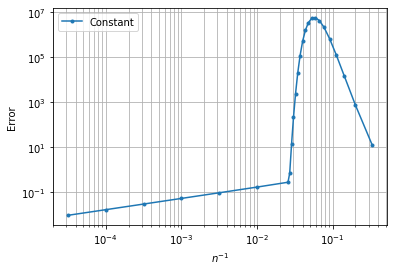

In [5]:
ns1, errors1 = [], []
for n_steps in np.hstack([np.arange(3, 40, 2), 10.**np.arange(2, 5, 0.5)]).astype(int):
    solver1 = ExplicitEulerWithConstantStepsize(func=stiff1, xlim=(0, np.pi), y0=y0, n_steps=n_steps).solve()
    ys_exact = stiff1_exact(solver1.xs)
    
    ns1.append(solver1.n_steps)
    errors1.append(np.linalg.norm(ys_exact[:,-1] - solver1.ys[:,-1]))
ns1, errors1 = np.array(ns1), np.array(errors1)

fig, ax = plt.subplots()
ax.loglog(1./ns1, errors1, '.-', label='Constant')
ax.set_xlabel(r'$n^{-1}$')
ax.set_ylabel('Error')
ax.grid(which='both')
ax.legend()

ステップ数を増やしても，誤差が減らないところがある．このような特徴がstiffnessと呼ばれる．

この挙動は次のようにして理解できる．
厳密解から少しずれた$y_1(x) = \cos x + v_1(x), y_2(x) = \sin x + v_2(x)$を考える．これを微分方程式に代入すると，
$$
\pmat{\df{v_1}{x} \\ \df{v_2}{x}} = \underbrace{\pmat{-16 & 12 \\ 12 & -9}}_{A} \pmat{v_1 \\ v_2}
$$
この行列$A$の固有値分解を$A = \Phi \Lambda \Phi^{-1}$とする．ただし，固有値$\Lambda = \pmat{0 & 0 \\ 0 & -25}$, 固有ベクトル$\Phi = \pmat{3 & 4 \\ 4 & -3}$である．

このとき，$\Phi \pmat{w_1 \\ w_2}$とおけば，$\Phi \pmat{\df{w_1}{x} \\ \df{w_2}{x}} = \Phi \Lambda \Phi^{-1} \Phi \pmat{w_1 \\ w_2}$となるので，結局
$$
\pmat{\df{w_1}{x} \\ \df{w_2}{x}} = \Lambda \pmat{w_1 \\ w_2} = \pmat{0 & 0 \\ 0 & -25} \pmat{w_1 \\ w_2}
$$
つまり，$w_1 = C_1, w_2 = C_2 e^{-25x}$となる．


このとき$w_2(x_{n-1}+h) = C_2 e^{-25x_{n-1}} e^{-25h} = w_x(x_{n-1}) e^{-25h}$である．$\norm{e^{-25h}}<1$であり，このことは，誤差$w_2$が減衰することを表す．

一方Euler法では，$w_2(x_{n-1}+h) \approx w_2(x_{n-1}) + hw'_2(x_{n-1}) =  w_2(x_{n-1}) + h (-25) C_2 e^{-25x_{n-1}} = w_2(x_{n-1}) + h (-25) w_2(x_{n-1}) = (1-25h) w_2(x_{n-1})$となる．
$\norm{1-25h} \le 1$，つまり$-1 \le 1-25h \le 1$となるのは，$-2 \le -25h \le 0$，つまり$0 \le h \le \frac{2}{25}$のときだけであり，ステップサイズ$h > \frac{2}{25}$のときには誤差は増幅することになる．


$h = \frac{2}{25}$のとき，$x$を0から$\pi$まで計算するときのステップ数は$n= \frac{\pi}{h} \approx 39.3$となるので，ステップ数38以下では発散したと分かる．

In [6]:
np.pi/(2./25)

39.269908169872416


#### Explicit Euler (variable stepsize)

Input:
- $\bv{f}(x, \bv{y})$
- interval of integration, $x_{min}, x_{max}$
- initial values, $\bv{y}(x_{min})$
- **tolerance (maximum permitted error), $T$**


次式はconstant stepsizeの場合と同じ:
$$
\begin{align*}
\bv{y}(x_{n}) &= \bv{y}(x_{n-1}) + h \bv{f}(x_{n-1}, \bv{y}(x_{n-1}) )
\end{align*}
$$

上式の計算後に，誤差を推定する:
$$
\norm{E} = \frac{h}{2} \norm{ \bv{f}(x_{n-1}, \bv{y}(x_{n-1})) - \bv{f}(x_{n}, \bv{y}(x_{n})) }
$$

もし$\norm{E} \lt T$であれば，ここで計算した$\bv{y}(x_n)$をacceptして，次ステップの計算に移る．

もし$\norm{E} \geq T$であれば，ここで計算した$\bv{y}(x_n)$をrejectして，stepsizeを
$$
h_{new} = h \sqrt{ \frac{T}{\norm{E}} }
$$
とし，再度$\bv{y}(x_n)$の計算に戻る．


> Euler法は二次以上の項を打ち切るので，$\norm{E} = O(h^2)$である．
このとき，$\norm{E} = C h^2$ ($C$は定数)とすると，$C h_{new}^2 = C h^2 \frac{T}{\norm{E}} = T$となるので，設定したtolerance程度になるようなstepsizeは$h_{new}$である．
>
>ただし$\norm{E}$は推定値なので，実用上は，安全率(safety factor) $S, (0 \leq S \leq 1)$を$T$にかけて，推定よりも誤差が大きい場合にも，真の誤差がtolerance以下に収まるようにするらしい．
本では，$S=0.9$の場合が紹介されている．
またstepsizeが小さく/大きくなりすぎることを防ぐため，minimum/maximum stepsize ratios ($M, m$)を設定するのも良いらしく，本では$M=2, m=0.5$とされているが，何に対するratioなのかは書いていない．おそらく何らかの形でstepsizeの初期値を与えている？

In [7]:
class ExplicitEulerWithVariableStepsize:
    def __init__(self, func, xlim, y0, atol, n_steps_max=int(1e6), safety_factor=0.9, first_step=None):
        self.func = func
        self.xlim = xlim
        self.y0   = y0
        self.atol = atol
        
        self.n_steps_max = n_steps_max
        self.safety_factor = safety_factor
        self.first_step = first_step
    
    def solve(self):
        self.xs, self.ys = self._solve(
            func = self.func, 
            xlim = self.xlim, 
            y0   = np.array(self.y0, dtype=np.float64), 
            atol = self.atol,
            n_steps_max   = self.n_steps_max,
            safety_factor = self.safety_factor,
            first_step = self.first_step
        )
        return self
    
    @staticmethod
    @njit
    def _solve(func, xlim, y0, atol, n_steps_max, safety_factor, first_step):
        xs = np.zeros(shape=(n_steps_max,), dtype=np.float64)
        ys = np.zeros(shape=(n_steps_max, len(y0)), dtype=np.float64)
        
        xs[0] = xlim[0]
        ys[0,:] = y0
        
        if first_step is None:
            h = xlim[1] - xlim[0]
        else:
            h = first_step
            
        for i in range(1, len(xs)):
            x1 = xs[i-1] + h
            y1 = ys[i-1,:] + h*func(xs[i-1], ys[i-1,:])
            error = 0.5*h * np.linalg.norm( func(xs[i-1], ys[i-1,:]) - func(x1, y1) )
            
            stepsize_ratio = np.sqrt(atol * safety_factor / error)
            h *= stepsize_ratio
            
            xs[i]   = xs[i-1] + h
            ys[i,:] = ys[i-1,:] + h*func(xs[i-1], ys[i-1,:])
            
            if xs[i] >= xlim[1]:
                break
        return xs[:i+1], ys[:i+1,:]

Text(0.5, 1.0, 'Number of steps: 30')

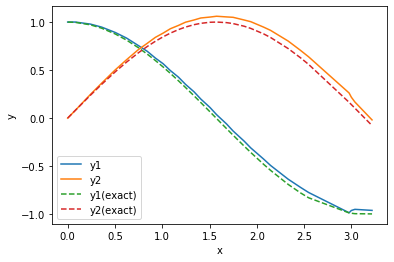

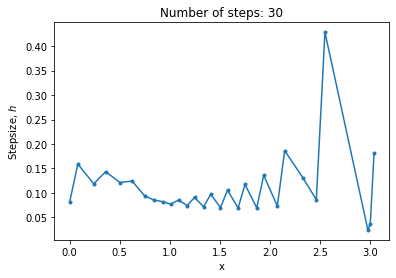

In [8]:
solver1 = ExplicitEulerWithVariableStepsize(func=stiff1, xlim=(0, np.pi), y0=y0, atol=0.01).solve()
ys_exact = stiff1_exact(solver1.xs)

fig, ax = plt.subplots()
ax.plot(solver1.xs, solver1.ys[:,0], label='y1')
ax.plot(solver1.xs, solver1.ys[:,1], label='y2')
ax.plot(solver1.xs, ys_exact[:,0], '--', label='y1(exact)')
ax.plot(solver1.xs, ys_exact[:,1], '--', label='y2(exact)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

fig, ax = plt.subplots()
ax.plot(solver1.xs[:-1], np.diff(solver1.xs), '.-')
ax.set_xlabel('x')
ax.set_ylabel(r'Stepsize, $h$')
ax.set_title(f'Number of steps: {len(solver1.xs)}')

Toleranceを0.01に設定したとき，ステップ数30で発散せずに計算ができている．
また各ステップで，ステップサイズが大きく変化していることも確認できる．

ステップ数，および設定したtoleranceに対する，厳密解と数値解の差を以下に示す．

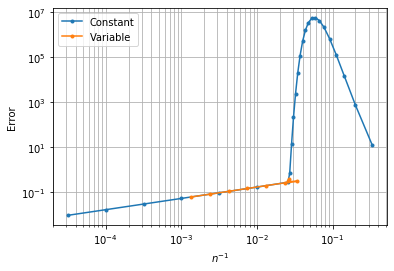

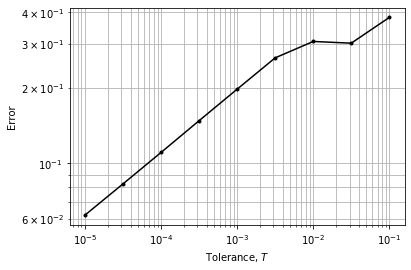

In [9]:
atols2, errors2 = [], []
ns2 = []
for atol in np.hstack([10.**np.arange(-5, -0.9, 0.5),]):
    solver1 = ExplicitEulerWithVariableStepsize(func=stiff1, xlim=(0, np.pi), y0=y0, atol=atol).solve()
    ys_exact = stiff1_exact(solver1.xs)
    
    atols2.append(atol)
    errors2.append(np.linalg.norm(ys_exact[:,-1] - solver1.ys[:,-1]))
    ns2.append(len(solver1.xs))
atols2 = np.array(atols2)
ns2, errors2 = np.array(ns2), np.array(errors2)

fig, ax = plt.subplots()
ax.loglog(1./ns1, errors1, '.-', label='Constant')
ax.loglog(1./ns2, errors2, '.-', label='Variable')
ax.set_xlabel(r'$n^{-1}$')
ax.set_ylabel('Error')
ax.grid(which='both')
ax.legend()


fig, ax = plt.subplots()
ax.loglog(atols2, errors2, 'k.-')
ax.set_xlabel(r'Tolerance, $T$')
ax.set_ylabel('Error')
ax.grid(which='both')

> 誤差$\norm{E}$は，
> 
> Euler法: $\bv{y}_{Euler}(x_n) = \bv{y}(x_{n-1}) + h \bv{f}(x_{n-1}, \bv{y}(x_{n-1}))$
>
> 台形則(trapezoital rule): $\bv{y}_{trapezoidal}(x_n) = \bv{y}(x_{n-1}) + \frac{h}{2} \left\{ \bv{f}(x_{n-1}, \bv{y}(x_{n-1})) + \bv{f}(x_{n}, \bv{y}(x_{n})) \right\}$
>
> の差で推定しており，
$$
\begin{align*}
\norm{E} &= \norm{\bv{y}_{trapezoidal}(x_n) - \bv{y}_{Euler}(x_n)} \\
&= \norm{ \bv{y}(x_{n-1}) + \frac{h}{2} \left\{ \bv{f}(x_{n-1}, \bv{y}(x_{n-1})) + \bv{f}(x_{n}, \bv{y}(x_{n})) \right\} - \bv{y}(x_{n-1}) - h \bv{f}(x_{n-1}, \bv{y}(x_{n-1})) } \\
&= \norm{ \frac{h}{2} \bv{f}(x_{n-1}, \bv{y}(x_{n-1})) - \frac{h}{2} \bv{f}(x_{n}, \bv{y}(x_{n})) }
\end{align*}
$$
このようにして推定する理由は，Euler法の誤差が$O(h^2)$であるのに対し，台形則の法が精度が良い(誤差が$O(h^3)$である)ため．台形則の誤差解析は以下の通り．
>> 厳密解は
$$
\begin{align*}
\bv{y}(x_n) &= \bv{y}(x_{n-1}) + \int_{x_{n-1}}^{x_n} \bv{f}(x) dx 
\end{align*}
$$
これと台形則で求めた値との差は，
$$
\begin{align*}
\bv{y}(x_n) - \bv{y}_{trapezoital}(x_n)
&= \bv{y}(x_{n-1}) + \int_{x_{n-1}}^{x_n} \bv{f}(x) dx  - \left( \bv{y}(x_{n-1}) + \frac{h}{2} \left\{ \bv{f}(x_{n-1}) + \bv{f}(x_{n}) \right\} \right) \\
&= \int_{x_{n-1}}^{x_n} \bv{f}(x) dx  - \frac{h}{2} \left\{ \bv{f}(x_{n-1}) + \bv{f}(x_{n}) \right\}
\end{align*}
$$
ここで，不定積分の変数を$x = x_{n-1}+t$とすると，
$$
\begin{align*}
\bv{y}(x_n) - \bv{y}_{trapezoital}(x_n)
&= \int_{0}^{h} \bv{f}(x_{n-1}+t) dt  - \frac{h}{2} \left\{ \bv{f}(x_{n-1}) + \bv{f}(x_{n}) \right\}
\end{align*}
$$
テイラー展開をすると，
$$
\begin{align*}
\bv{y}(x_n) - \bv{y}_{trapezoital}(x_n)
&= \int_{0}^{h} \left( \bv{f}(x_{n-1}) + t\bv{f}'(x_{n-1}) + \frac{t^2}{2} \bv{f}''(x_{n-1}) + \cdots \right) dt  
- \frac{h}{2} \left\{ \bv{f}(x_{n-1}) + \bv{f}(x_{n-1}) + h\bv{f}'(x_{n-1}) + \frac{h^2}{2} \bv{f}''(x_{n-1}) + \cdots \right\} \\
&= \left[ t\bv{f}(x_{n-1}) + \frac{t^2}{2} \bv{f}'(x_{n-1}) + \frac{t^3}{3 \cdot 2} \bv{f}''(x_{n-1}) + \cdots \right]_0^h
- \left\{ h\bv{f}(x_{n-1}) + \frac{h^2}{2} \bv{f}'(x_{n-1}) + \frac{h^3}{3 \cdot 2} \bv{f}''(x_{n-1}) + \cdots \right\} \\
&= h\bv{f}(x_{n-1}) + \frac{h^2}{2} \bv{f}'(x_{n-1}) + \frac{h^3}{3 \cdot 2} \bv{f}''(x_{n-1}) + \cdots
- \left\{ h\bv{f}(x_{n-1}) + \frac{h^2}{2} \bv{f}'(x_{n-1}) + \frac{h^3}{3 \cdot 2} \bv{f}''(x_{n-1}) + \cdots \right\} \\
&= - \frac{h^3}{12} \bv{f}''(x_{n-1}) + \cdots
\end{align*}
$$
よって$\norm{\bv{y}(x_n) - \bv{y}_{trapezoital}(x_n)} = O(h^3)$である．

#### Implicit Euler

Input:
- $\bv{f}(x, \bv{y})$
- interval of integration, $x_{min}, x_{max}$
- initial values, $\bv{y}(x_{min})$
- stepsize, $h$
- **tolerance for the convergence of iteration, $T$**

微分係数を$x_{n-1}$ではなく$x_{n}$で求める形の式:
$$
\begin{align*}
\bv{y}(x_{n}) &= \bv{y}(x_{n-1}) + h \bv{y}'(x_{n}) \\
& = \bv{y}(x_{n-1}) + h \bv{f}(x_{n}, \bv{y}(x_{n}) )
\end{align*}
$$
を満たすような$\bv{y}(x_n)$の近似値を，次の反復計算($k=1, 2, \cdots$)を，$\norm{\bv{y}^{[k]} - \bv{y}^{[k-1]}} \leq T$となる(収束する)まで計算して求める:
$$
\bv{y}^{[k]} = \bv{y}(x_{n-1}) + h \bv{f}(x_{n}, \bv{y}^{[k-1]})
$$

In [10]:
class ImplicitEuler:
    def __init__(self, func, xlim, y0, atol, n_steps, n_iter_max=int(1e5)):
        self.func = func
        self.xlim = xlim
        self.y0   = y0
        self.atol = atol
        self.n_steps = n_steps
        self.n_iter_max = n_iter_max
        
    def solve(self):
        self.xs, self.ys, self.ns_iter = self._solve(
            func = self.func, 
            xlim = self.xlim, 
            y0   = np.array(self.y0, dtype=np.float64), 
            atol = self.atol,
            n_steps = self.n_steps,
            n_iter_max = self.n_iter_max,
        )
        return self
    
    @staticmethod
    @njit
    def _solve(func, xlim, y0, atol, n_steps, n_iter_max):
        xs = np.linspace(xlim[0], xlim[1], n_steps)
        ys = np.zeros(shape=(len(xs), len(y0)), dtype=np.float64)
        ys[0,:] = y0
        
        ns_iter = np.zeros_like(xs)
        
        for i in range(1, len(xs)):
            h = xs[i] - xs[i-1]
            y1_old = ys[i-1,:] + h*func(xs[i-1], ys[i-1,:])
            for i_iter in range(n_iter_max):
                y1 = ys[i-1,:] + h*func(xs[i], y1_old)
                if np.linalg.norm(y1 - y1_old) < atol:
                    break
                y1_old[:] = y1[:]
            ns_iter[i] = i_iter

            ys[i,:] = y1
        return xs, ys, ns_iter

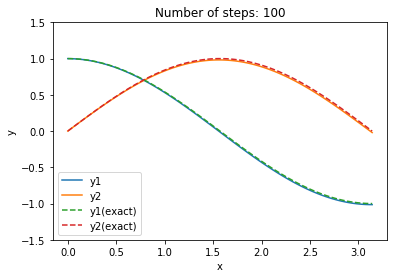

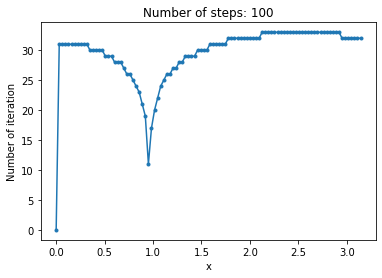

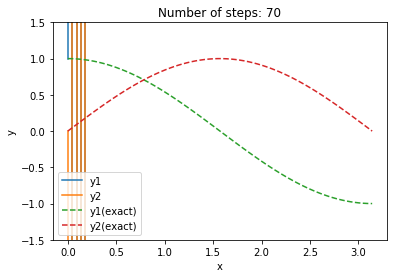

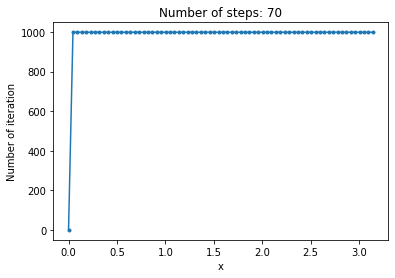

In [11]:
for n_steps in [100, 70]:
    solver1 = ImplicitEuler(func=stiff1, xlim=(0, np.pi), y0=y0, atol=1e-6, n_steps=n_steps, n_iter_max=1000).solve()
    ys_exact = stiff1_exact(solver1.xs)

    fig, ax = plt.subplots()
    ax.plot(solver1.xs, solver1.ys[:,0], label='y1')
    ax.plot(solver1.xs, solver1.ys[:,1], label='y2')
    ax.plot(solver1.xs, ys_exact[:,0], '--', label='y1(exact)')
    ax.plot(solver1.xs, ys_exact[:,1], '--', label='y2(exact)')
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(f'Number of steps: {len(solver1.xs)}')

    # print(solver1.ys)
    fig, ax = plt.subplots()
    ax.plot(solver1.xs, solver1.ns_iter, '.-')
    ax.set_xlabel('x')
    ax.set_ylabel(r'Number of iteration')
    ax.set_title(f'Number of steps: {len(solver1.xs)}')

ステップ数100だと計算できたが，ステップ数70にすると，すぐに発散した．
おそらく，$\bv{y}^{[k]} = \bv{y}(x_{n-1}) + h \bv{f}(x_{n}, \bv{y}^{[k-1]})$の反復計算をするときに誤差が増幅してしまうのだと思う...

本には，この問題の場合には陰解法の式は
$$
\pmat{1+16h & -12h \\ -12h & 1+9h} \pmat{y_1 (x_{n}) \\ y_2 (x_n)} = \pmat{ y_1(x_{n-1}) + 16h\cos x_n - 13h\sin x_n \\ y_2(x_{n-1}) - 11h\cos x_n + 9h \sin x_n }
$$
と書けるため，陽的に解くことができると示されており，以下に計算するように確かにステップ数30とかでも計算ができるようになる．

In [12]:
class ImplicitEulerForStiff1:
    def __init__(self, xlim, y0, n_steps):
        self.xlim = xlim
        self.y0   = y0
        self.n_steps = n_steps
        
    def solve(self):
        self.xs, self.ys = self._solve(
            xlim = self.xlim, 
            y0   = np.array(self.y0, dtype=np.float64), 
            n_steps = self.n_steps,
        )
        return self
    
    @staticmethod
    @njit
    def _solve(xlim, y0, n_steps):
        xs = np.linspace(xlim[0], xlim[1], n_steps)
        ys = np.zeros(shape=(len(xs), len(y0)), dtype=np.float64)
        ys[0,:] = y0
        
        h = np.mean(np.diff(xs))
        A = np.array([[1.+16.*h, -12.*h],[-12.*h, 1.+9.*h]], dtype=np.float64)
        Ainv = np.linalg.inv(A).astype(np.float64)
        
        for i in range(1, len(xs)):
            x1, y1 = xs[i-1], ys[i-1,:]
            b = np.array([
                y1[0] + 16.*h*np.cos(x1) - 13.*h*np.sin(x1),
                y1[1] - 11.*h*np.cos(x1) +  9.*h*np.sin(x1)
            ])
            ys[i,:] = np.dot(Ainv, b[:])
        return xs, ys

In [ ]:
solver1 = ImplicitEulerForStiff1(xlim=(0, np.pi), y0=y0, n_steps=30).solve()
ys_exact = stiff1_exact(solver1.xs)

fig, ax = plt.subplots()
ax.plot(solver1.xs, solver1.ys[:,0], label='y1')
ax.plot(solver1.xs, solver1.ys[:,1], label='y2')
ax.plot(solver1.xs, ys_exact[:,0], '--', label='y1(exact)')
ax.plot(solver1.xs, ys_exact[:,1], '--', label='y2(exact)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Number of steps: {len(solver1.xs)}')

In [ ]:
ns3, errors3 = [], []
for n_steps in np.hstack([np.arange(3, 40, 2), 10.**np.arange(2, 5, 0.5)]).astype(int):
    solver1 = ImplicitEulerForStiff1(xlim=(0, np.pi), y0=y0, n_steps=n_steps).solve()
    ys_exact = stiff1_exact(solver1.xs)
    
    ns3.append(n_steps)
    errors3.append(np.linalg.norm(ys_exact[:,-1] - solver1.ys[:,-1]))
ns3, errors3 = np.array(ns3), np.array(errors3)

In [ ]:
fig, ax = plt.subplots()
ax.loglog(1./ns1, errors1, '.-', label='Constant')
ax.loglog(1./ns2, errors2, '.-', label='Variable')
ax.loglog(1./ns3, errors3, 'x:', label='Implicit', lw=1)
ax.set_xlabel(r'$n^{-1}$')
ax.set_ylabel('Error')
ax.grid(which='both')
ax.legend()


In [ ]:
1/400e3